In [1]:
import pandas as pd
import scipy
import numpy as np
from math import sin, cos, pi, atan2, asin, sqrt
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m
ms2mph = 0.6818182*ft
gs2mph = ms2mph * 9.8

# Parameters
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = 3.1415
ft = 3.2884  # ft/m

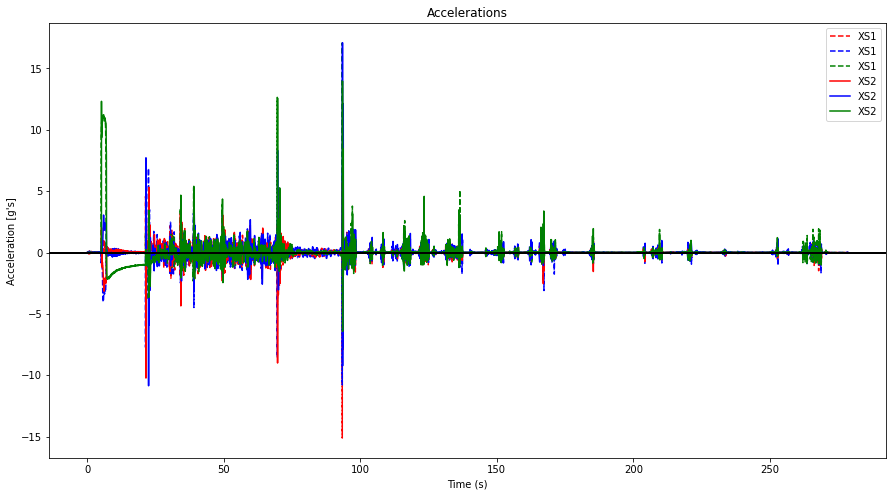

In [3]:
################## DATA FRAME ##################
datafile = 'Trunc_NASA_S1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
all_time1 = df['Timestamp'].values
tdata1 = all_time1
tdata1 = tdata1 - all_time1[0]
ax_g_S1 = df['LinearAccelNed X']/9.8
ay_g_S1 = df['LinearAccelNed Y']/9.8
az_g_S1 = df['LinearAccelNed Z']/-9.8

################## DATA FRAME ##################
datafile = 'Trunc_NASA_S2.csv'
df2 = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
all_time2 = df2['Timestamp'].values
tdata2 = all_time2
tdata2 = tdata2 - all_time2[0]
ax_g_S2 = df2['LinearAccelNed X']/9.8
ay_g_S2 = df2['LinearAccelNed Y']/9.8
az_g_S2 = df2['LinearAccelNed Z']/-9.8


fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tdata1, ax_g_S1, color='red', label='XS1', linestyle='--')
ax.plot(tdata1, ay_g_S1, color='blue', label='XS1', linestyle='--')
ax.plot(tdata1, az_g_S1, color='green', label='XS1', linestyle='--')
ax.plot(tdata2, ax_g_S2, color='red', label='XS2')
ax.plot(tdata2, ay_g_S2, color='blue', label='XS2')
ax.plot(tdata2, az_g_S2, color='green', label='XS2')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Accelerations")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
plt.show()

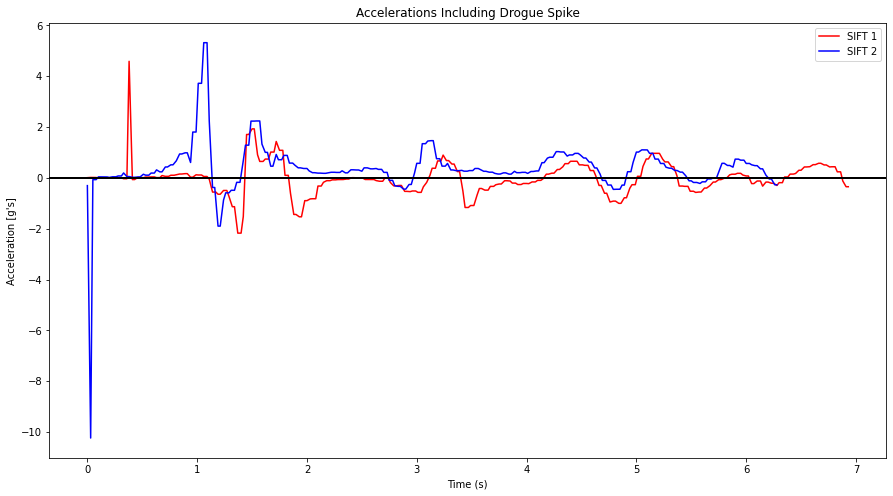

In [4]:
start_S1_with_spike = 825
end_S1_with_spike = 1100
tdata_S1_with_spike = tdata1[start_S1_with_spike:end_S1_with_spike]
axg_S1_with_spike = list(ax_g_S1[start_S1_with_spike:end_S1_with_spike])
tdata_S1_with_spike = tdata_S1_with_spike - tdata_S1_with_spike[0]

start_S2_with_spike = 850
end_S2_with_spike = 1100
tdata_S2_with_spike = tdata2[start_S2_with_spike:end_S2_with_spike]
axg_S2_with_spike = list(ax_g_S2[start_S2_with_spike:end_S2_with_spike])
tdata_S2_with_spike = tdata_S2_with_spike - tdata_S2_with_spike[0]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S1_with_spike, axg_S1_with_spike, color='red', label='SIFT 1')
l2 = ax.plot(tdata_S2_with_spike, axg_S2_with_spike, color='blue', label='SIFT 2')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Accelerations Including Drogue Spike")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
plt.show()

In [5]:
def find_peak_and_wait(ax, t, thresh=4, delay=2):
    axn = np.array(ax)
    above_threshold = axn > thresh
    first_pass = list(above_threshold).index(True)
    print(f"First pass at index {first_pass} at time {t[first_pass]}")
    
    i = first_pass
    while t[i] < (t[first_pass] + 2):
        i += 1
    return first_pass


def calc_moving_avg(axg21t, n, tdata21, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80):        
    if dynamic_window:
        axg21s_1 = pd.Series(axg21t[0:dynamic_n_timing]).rolling(window=n).mean().iloc[n-1:].values
        axg21s_2 = pd.Series(axg21t).rolling(window=dynamic_n).mean().iloc[n-1:].values[dynamic_n_timing:]
        new_axg21s = list(axg21s_1) + list(axg21s_2)
    else:
        axg21s = pd.Series(axg21t).rolling(window=n).mean().iloc[n-1:].values
        new_axg21s = list(axg21s)
    while len(new_axg21s) < len(tdata21):
        new_axg21s = [0] + list(new_axg21s) + [0]
    return new_axg21s

In [6]:
drogue_peak_idx_S1 = find_peak_and_wait(np.array(ax_g_S1), all_time1)
start_drogue_S1 = drogue_peak_idx_S1 + 10
end_drogue_S1 = 1100
tdata_S1 = tdata1[start_drogue_S1:end_drogue_S1]
axgt_S1 = list(ax_g_S1[start_drogue_S1:end_drogue_S1])

#drogue_peak_idx_S2 = find_peak_and_wait(np.array(ax_g_S2), all_time2)
start_drogue_S2 = 890
end_drogue_S2 = 1100
tdata_S2 = tdata2[start_drogue_S2:end_drogue_S2]
axgt_S2 = list(ax_g_S2[start_drogue_S2:end_drogue_S2])

First pass at index 840 at time 21.31000000000131


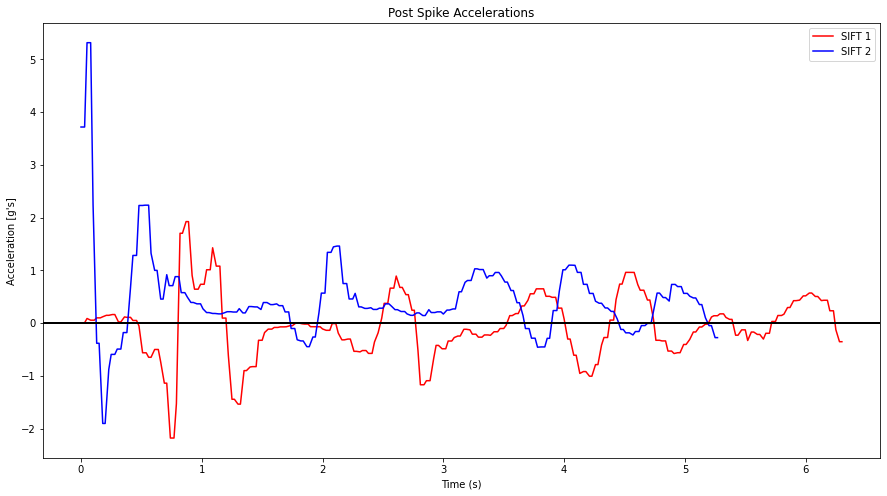

In [7]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S1-tdata_S1[0], axgt_S1, color='red', label='SIFT 1')
l2 = ax.plot(tdata_S2-tdata_S2[0], axgt_S2, color='blue', label='SIFT 2')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Post Spike Accelerations")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")

ax.legend()
plt.show()

SIFT 1


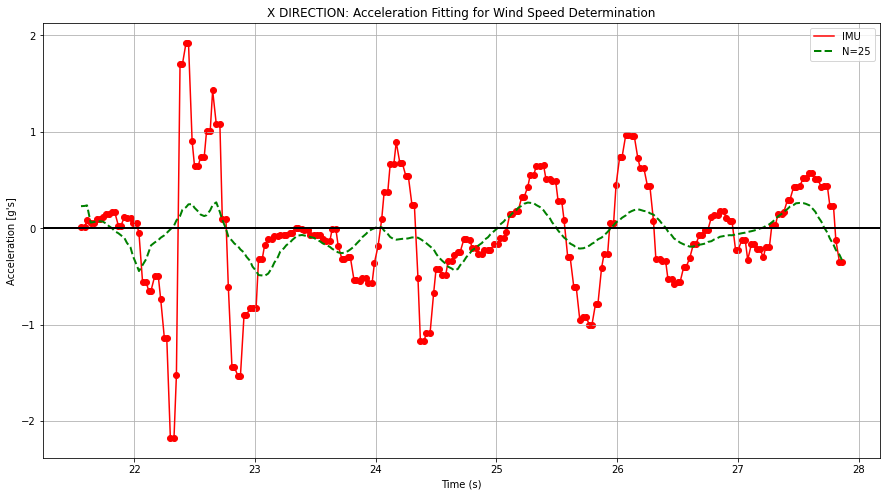

Estimated Wind Speed via Original IMU Signal: -6.45 mph
Estimated Wind Speed via Moving Average (25): -8.15 mph
Estimated Wind Speed via Moving Average (65): -8.28 mph


In [8]:
print("SIFT 1")
dt = 0
for i in range(0, 100):
    dt += tdata_S1[i+1] - tdata_S1[i]
dt /= 100

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ax_g_S1, 25, tdata1)
new_axg_25 = axg21t[start_drogue_S1:end_drogue_S1]
axg21t = calc_moving_avg(ax_g_S1, 65, tdata1)
new_axg_65 = axg21t[start_drogue_S1:end_drogue_S1]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S1, ax_g_S1[start_drogue_S1:end_drogue_S1], color='red', label='IMU')
l2 = ax.scatter(tdata_S1, ax_g_S1[start_drogue_S1:end_drogue_S1], color='red')
l25 = ax.plot(tdata_S1, new_axg_25, color='green', label='N=25', linewidth=2, linestyle="--")
#l65 = ax.plot(tdata_S1, new_axg_65, color='orange', label='N=65', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("X DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
ax.grid()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(ax_g_S1[start_drogue_S1:end_drogue_S1], dx=dt)
result_trapz_MA25 = scipy.integrate.trapz(new_axg_25, dx=dt)
result_trapz_MA65 = scipy.integrate.trapz(new_axg_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.2f} mph")

SIFT 2


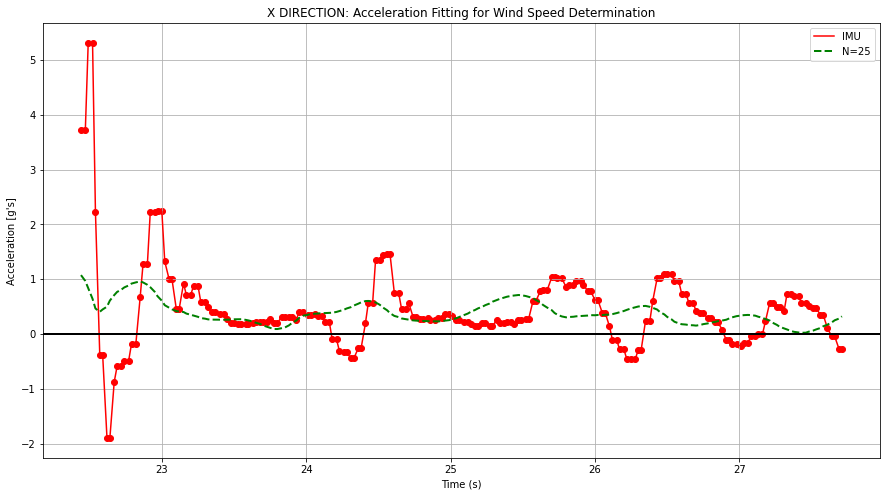

Estimated Wind Speed via Original IMU Signal: 51.58 mph
Estimated Wind Speed via Moving Average (25): 43.82 mph
Estimated Wind Speed via Moving Average (65): -8.21 mph


In [9]:
print("SIFT 2")
dt2 = 0
for i in range(0, 100):
    dt2 += tdata_S2[i+1] - tdata_S2[i]
dt2 /= 100

#calculate moving average
#dynamic_window=False, dynamic_n_timing=140, dynamic_n=80
axg21t = calc_moving_avg(ax_g_S2, 25, tdata_S2)
new_axg_25_S2 = axg21t[start_drogue_S2:end_drogue_S2]
axg21t = calc_moving_avg(ax_g_S2, 65, tdata_S2)
new_axg_65_S2 = axg21t[start_drogue_S2:end_drogue_S2]
dt = tdata_S2[1] - tdata_S2[0]

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red', label='IMU')
l2 = ax.scatter(tdata_S2, ax_g_S2[start_drogue_S2:end_drogue_S2], color='red')
l25 = ax.plot(tdata_S2, new_axg_25_S2, color='green', label='N=25', linewidth=2, linestyle="--")
#l65 = ax.plot(tdata_S1, new_axg_65, color='orange', label='N=65', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("X DIRECTION: Acceleration Fitting for Wind Speed Determination")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
ax.grid()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(ax_g_S2[start_drogue_S2:end_drogue_S2], dx=dt2)
result_trapz_MA25 = scipy.integrate.trapz(new_axg_25_S2, dx=dt2)
result_trapz_MA65 = scipy.integrate.trapz(new_axg_65, dx=dt2)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMU:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (65): {gs2mph*result_trapz_MA65:.2f} mph")

## Y Direction

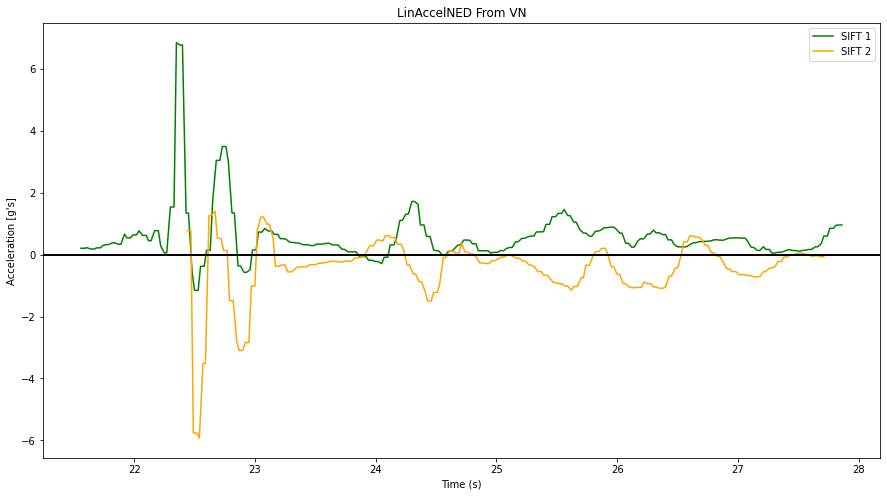

In [10]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S1, ay_g_S1[start_drogue_S1:end_drogue_S1], color='green', label='SIFT 1')
l2 = ax.plot(tdata_S2, ay_g_S2[start_drogue_S2:end_drogue_S2], color='orange', label='SIFT 2')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
plt.show()

In [11]:
ayg_S1_t = ay_g_S1[start_drogue_S1:end_drogue_S1]
ayg_S2_t = ay_g_S2[start_drogue_S2:end_drogue_S2]

n=25
#calculate moving average
ayg_S1_25 = pd.Series(ayg_S1_t).rolling(window=n).mean().iloc[n-1:].values
new_ayg_S1_25 = list(ayg_S1_25)
zero_padding_size = (len(tdata_S1) - len(list(ayg_S1_25))) // 2
for i in range(zero_padding_size):
    new_ayg_S1_25 = [0] + list(new_ayg_S1_25) + [0]
while len(new_ayg_S1_25) < len(tdata_S1):
    new_ayg_S1_25 = [0] + new_ayg_S1_25
# SIFT 2
ayg_S2_25 = pd.Series(ayg_S2_t).rolling(window=n).mean().iloc[n-1:].values
new_ayg_S2_25 = list(ayg_S2_25)
zero_padding_size = (len(tdata_S2) - len(list(ayg_S2_25))) // 2
for i in range(zero_padding_size):
    new_ayg_S2_25 = [0] + list(new_ayg_S2_25) + [0]
while len(new_ayg_S2_25) < len(tdata_S2):
    new_ayg_S2_25 = [0] + new_ayg_S2_25
    
n=15
#calculate moving average
ayg_S1_65 = pd.Series(ayg_S1_t).rolling(window=n).mean().iloc[n-1:].values
new_ayg_S1_65 = list(ayg_S1_65)
zero_padding_size = (len(tdata_S1) - len(list(ayg_S1_65))) // 2
for i in range(zero_padding_size):
    new_ayg_S1_65 = [0] + list(new_ayg_S1_65) + [0]
while len(new_ayg_S1_65) < len(tdata_S1):
    new_ayg_S1_65 = [0] + new_ayg_S1_65
# SIFT 2
ayg_S2_65 = pd.Series(ayg_S2_t).rolling(window=n).mean().iloc[n-1:].values
new_ayg_S2_65 = list(ayg_S2_65)
zero_padding_size = (len(tdata_S2) - len(list(ayg_S2_65))) // 2
for i in range(zero_padding_size):
    new_ayg_S2_65 = [0] + list(new_ayg_S2_65) + [0]
while len(new_ayg_S2_65) < len(tdata_S2):
    new_ayg_S2_65 = [0] + new_ayg_S2_65

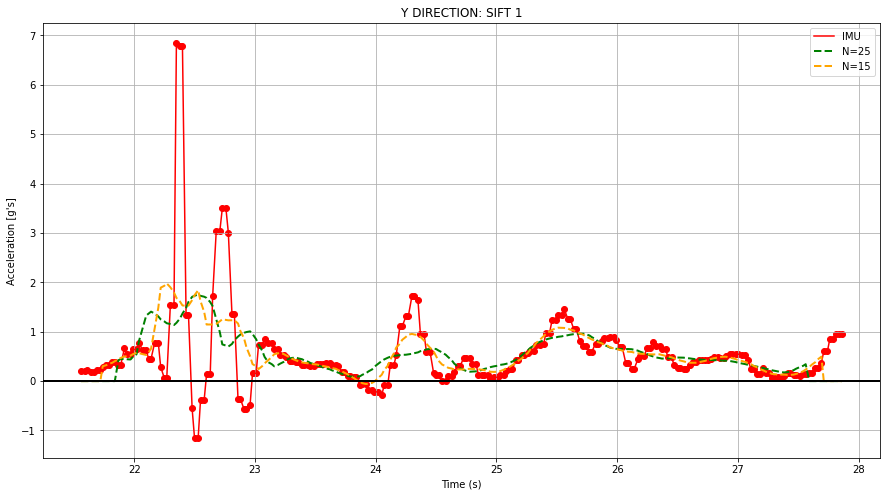

Estimated Wind Speed via Original IMU Signal: 94.45 mph
Estimated Wind Speed via Moving Average (25): 88.24 mph
Estimated Wind Speed via Moving Average (15): 90.53 mph


In [12]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S1, ayg_S1_t, color='red', label='IMU')
l2 = ax.scatter(tdata_S1, ayg_S1_t, color='red')
l25 = ax.plot(tdata_S1, new_ayg_S1_25, color='green', label='N=25', linewidth=2, linestyle="--")
l65 = ax.plot(tdata_S1, new_ayg_S1_65, color='orange', label='N=15', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Y DIRECTION: SIFT 1")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
ax.grid()
plt.show()

result_trapz_IMUy = scipy.integrate.trapz(ayg_S1_t, dx=dt)
result_trapz_MA25y = scipy.integrate.trapz(new_ayg_S1_25, dx=dt)
result_trapz_MA65y = scipy.integrate.trapz(new_ayg_S1_65, dx=dt)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMUy:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25y:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (15): {gs2mph*result_trapz_MA65y:.2f} mph")

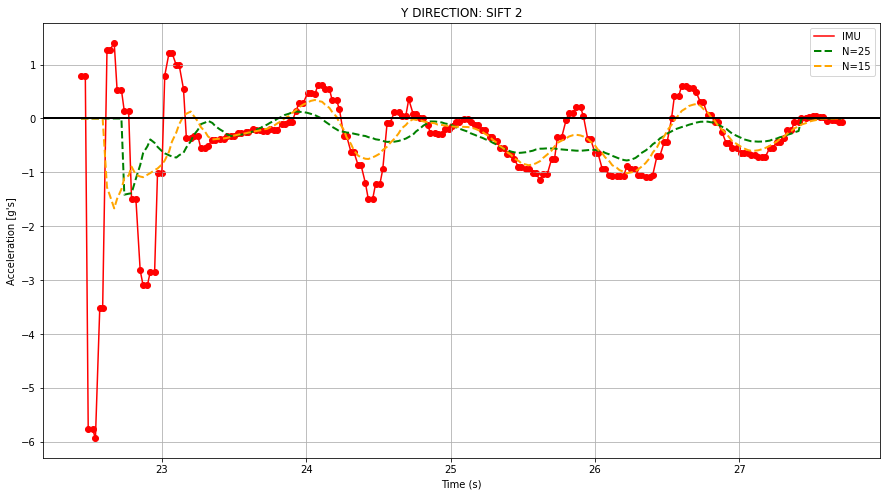

Estimated Wind Speed via Original IMU Signal: -49.28 mph
Estimated Wind Speed via Moving Average (25): -37.43 mph
Estimated Wind Speed via Moving Average (15): -41.52 mph


In [13]:
fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l2 = ax.plot(tdata_S2, ayg_S2_t, color='red', label='IMU')
l2 = ax.scatter(tdata_S2, ayg_S2_t, color='red')
l25 = ax.plot(tdata_S2, new_ayg_S2_25, color='green', label='N=25', linewidth=2, linestyle="--")
l65 = ax.plot(tdata_S2, new_ayg_S2_65, color='orange', label='N=15', linewidth=2, linestyle="--")
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Y DIRECTION: SIFT 2")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
ax.legend()
ax.grid()
plt.show()

result_trapz_IMUy = scipy.integrate.trapz(ayg_S2_t, dx=dt2)
result_trapz_MA25y = scipy.integrate.trapz(new_ayg_S2_25, dx=dt2)
result_trapz_MA65y = scipy.integrate.trapz(new_ayg_S2_65, dx=dt2)

print(f"Estimated Wind Speed via Original IMU Signal: {gs2mph*result_trapz_IMUy:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (25): {gs2mph*result_trapz_MA25y:.2f} mph")
print(f"Estimated Wind Speed via Moving Average (15): {gs2mph*result_trapz_MA65y:.2f} mph")

# 22 Full-Scale

In [14]:
################## DATA FRAME ##################
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]
L = tdata.shape[0]

ax_vn = df['LinearAccelNed X']* ft
ay_vn = df['LinearAccelNed Y']* ft
az_vn = df['LinearAccelNed Z']* -ft

ax_g22 = df['LinearAccelNed X']/9.8 #* ft
ay_g22 = df['LinearAccelNed Y']/9.8 #* ft
az_g22 = df['LinearAccelNed Z']/-9.8 #* -ft

axg22t = list(ax_g22)
start22 = 670
end22 = 1000
tdata22 = tdata[start22:end22]
axg22t = ax_g22[start22:end22]

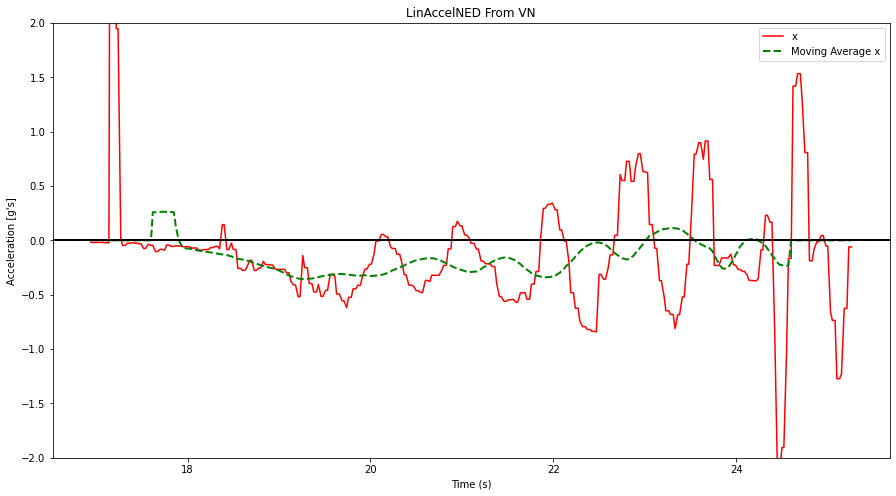

Estimated Wind Speed via Original IMU Signal: -9.31019860 m/s
Estimated Wind Speed via Moving Average: -10.80348860 m/s
Estimated Wind Speed via Original, Zoomed In: -9.13216905 m/s


In [15]:
n=55

#calculate moving average
axg22s = pd.Series(axg22t).rolling(window=n).mean().iloc[n-1:].values
new_axg22s = list(axg22s)
zero_padding_size = (len(tdata22) - len(list(axg22s))) // 2
for i in range(zero_padding_size):
    new_axg22s = [0] + list(new_axg22s) + [0]
while len(new_axg22s) < len(tdata22):
    new_axg22s = [0] + new_axg22s

fig1 = plt.figure(1, figsize=(15,8))
ax = plt.subplot(111)
l1 = ax.plot(tdata22, ax_g22[start22:end22], color='red', label='x')
l2 = ax.plot(tdata22, new_axg22s, color='green', label='Moving Average x', linewidth=2, linestyle="--")
l2 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [g's]")
plt.ylim((-2, 2))

ax.legend()
plt.show()

result_trapz_IMU = scipy.integrate.trapz(ax_g22[start22:end22], dx=0.025)
result_trapz_MA = scipy.integrate.trapz(new_axg22s, dx=0.025)
result_trapz_ZOOM = scipy.integrate.trapz(axg22t[75:280], dx=0.025)

print(f"Estimated Wind Speed via Original IMU Signal: {9.8*result_trapz_IMU:.8f} m/s")
print(f"Estimated Wind Speed via Moving Average: {9.8*result_trapz_MA:.8f} m/s")
print(f"Estimated Wind Speed via Original, Zoomed In: {9.8*result_trapz_ZOOM:.8f} m/s")